In [2]:
import gunpowder as gp
import numpy as np
import zarr
import matplotlib.pyplot as plt
import math

In [3]:
def imshowPair(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[1].imshow(img2)

def imshow(image):
  if len(image.shape) == 2:
    plt.imshow(image)
  elif len(image.shape) == 3:
    plt.imshow(image.transpose(1, 2, 0))
  else:
    fig, axes = plt.subplots(1, image.shape[0], figsize=(10, 10), sharex=True, sharey=True)
    for i, im in enumerate(image):
      axes[i].imshow(im.transpose(1, 2, 0))
    plt.show()

In [4]:
pathZarr = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/data.zarr"
data = zarr.open(pathZarr, mode='r')
data.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='gt (50, 2048, 2048) f…

In [5]:
pathZarr = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/data.zarr"

raw = gp.ArrayKey('RAW')
gt = gp.ArrayKey('GT')

source = gp.ZarrSource(
    pathZarr,
    {
      raw: 'tr',
      gt: 'gt'
    },
    {
      raw: gp.ArraySpec(interpolatable=True),
      gt: gp.ArraySpec(interpolatable=False)
    })

request = gp.BatchRequest()


request[gt] = gp.Roi((0, 0, 0), (1, 256, 256))
request[raw] = gp.Roi((0, 0, 0), (1, 256, 256))

intensity_augment = gp.IntensityAugment(
  raw,
  scale_min=0.8,
  scale_max=1.2,
  shift_min=-0.2,
  shift_max=0.2)
noise_augment = gp.NoiseAugment(raw)


pipeline = (
    source +
    gp.Normalize(raw, factor = 1.0 / (256 ** 4 - 1)) +
    gp.RandomLocation() +
    gp.SimpleAugment(transpose_only = [1, 2])
)

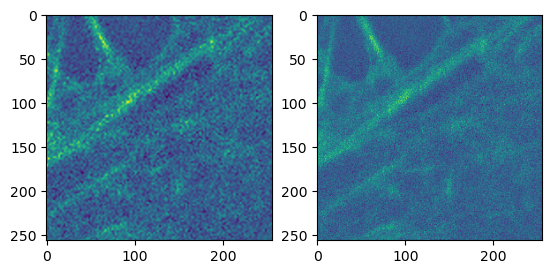

In [13]:
with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshowPair(batch[raw].data.squeeze(), batch[gt].data.squeeze())